<a href="https://colab.research.google.com/github/Otavio8888/macroeconometric/blob/main/impulso_decomposto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decomposição do Impulso de Crédito no Brasil usando Python


A compreensão dos ciclos econômicos modernos exige ferramentas que vão além da análise superficial de estoques e fluxos simples. Nesse contexto, o **Impulso de Crédito** surge como um indicador antecedente fundamental para prever o comportamento da atividade econômica.



## Impulso de Crédito

A teoria econômica tradicional muitas vezes analisa o crescimento do estoque de crédito. No entanto, para entender o impacto do crédito no crescimento do PIB (uma variável de fluxo), é necessário observar a aceleração do crédito, e não apenas sua velocidade.

A motivação deste estudo baseia-se na metodologia de **Biggs et al. (2010)**, que argumenta que a demanda agregada é impulsionada pela *variação* no fluxo de novos empréstimos. Ou seja, para que o crédito contribua positivamente para o crescimento do PIB, o fluxo de crédito deve ser crescente. Se o crédito cresce a uma taxa constante, o impulso é zero; se o crescimento do crédito desacelera (mesmo que ainda positivo), o impulso é negativo, agindo como um freio na economia. O impulso de crédito é definido como:

$$
\text{Impulso de Crédito}_t = \left ( \frac{\text{Saldo}_t - \text{Saldo}_{t-1} }{\text{PIB}_t}\right ) - \left ( \frac{\text{Saldo}_{t-1} - \text{Saldo}_{t-2}}{\text{PIB}_{t-1}} \right )
$$

Onde Saldo é o estoque de crédito da economia e PIB é o fluxo nominal de atividade econômica.

#### Metodologia e Dados

Para a construção do indicador, foram utilizados dados públicos extraídos diretamente do Sistema Gerenciador de Séries Temporais (SGS) do Banco Central do Brasil, via API, demonstrando a capacidade do Python de integrar fontes de dados em tempo real.

As variáveis selecionadas compreendem o período de 2007 a 2025 e incluem:
1.  **Saldos de Crédito:** Estoques totais, segregados em **Recursos Livres** (determinados pelas condições de mercado) e **Recursos Direcionados** (crédito subsidiado ou regulado, como habitacional e rural).
2.  **Atividade Econômica:** O PIB nominal mensal para cálculo o indicador, e  o IBC-Br (Índice de Atividade Econômica do Banco Central) para comparação com o indicador de impulso de crédito, visando entender o efeito contemporâneo e defasado do indicador em relação a atividade econômica.

A fórmula aplicada define o Impulso de Crédito como a variação do fluxo de crédito em relação ao PIB. Matematicamente, subtrai-se o fluxo de crédito do período anterior (ajustado pelo PIB) do fluxo atual. Para suavizar a volatilidade inerente aos dados mensais, utiliza-se uma janela móvel de 12 meses (acumulado anual).

## Coleta de dados

In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

# Paleta de cores
cores_am = ["#282f6b", "#1B998B", "#FF7A00", "#00798C", "#b22200",
            "#50514F", "#003366", "#eace3f", "#005A9C", "#808080", "#2E294E"]

# Códigos das séries do BCB
codigos = {
    "saldo_livre": 20542,
    "saldo_direcionado": 20593,
    "saldo_total": 20539,
    "pib": 4380,
    "ibc": 24364
}

# Coleta de dados
dados_brutos = {}

for nome, cod in codigos.items():
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{cod}/dados?formato=csv&dataInicial=01/03/2007&dataFinal="

    dados = pd.read_csv(
        filepath_or_buffer=url + pd.to_datetime("today").strftime("%d/%m/%Y"),
        sep=";",
        decimal=",",
        converters={"data": lambda x: pd.to_datetime(x, format="%d/%m/%Y")},
        index_col="data",
        names=["data", nome],
        skiprows=1
    )
    dados_brutos[nome] = dados

# Juntar todos os dados
df_completo = dados_brutos["saldo_total"]
for nome, df in dados_brutos.items():
    if nome != "saldo_total":
        df_completo = df_completo.join(df, how="inner")

In [ ]:
df_completo

,saldo_total,saldo_livre,saldo_direcionado,pib,ibc
data,,,,,
2007-03-01,762353,490460,271893,223208.6,83.88148
2007-04-01,781888,505753,276135,218931.2,84.99710
2007-05-01,793133,514647,278486,227535.3,85.78819
2007-06-01,805488,525046,280442,224188.2,86.41450
2007-07-01,824442,541348,283093,230916.3,86.91931
...,...,...,...,...,...
2025-07-01,6732353,3877337,2855016,1095262.0,108.34416
2025-08-01,6772151,3894986,2877165,1066136.7,108.75658
2025-09-01,6850359,3932501,2917858,1074308.9,108.62663


## Cálculo do Impulso de Crédito

In [ ]:
# Função para calcular impulso de crédito
def calcular_impulso(df, coluna_saldo, coluna_pib="pib"):
    """
    Calcula o impulso de crédito conforme fórmula de Biggs et al (2010)
    """

    impulso = (
        (df[coluna_saldo] - df[coluna_saldo].shift(12)) / df[coluna_pib] -
        (df[coluna_saldo].shift(12) - df[coluna_saldo].shift(24)) / df[coluna_pib].shift(12)
    ).rolling(12).sum()

    return impulso

# Calcular impulsos
df_completo = df_completo.assign(
    impulso_total=lambda x: calcular_impulso(x, "saldo_total"),
    impulso_livre=lambda x: calcular_impulso(x, "saldo_livre"),
    impulso_direcionado=lambda x: calcular_impulso(x, "saldo_direcionado"),
    ibc_var=lambda x: ((x.ibc / x.ibc.shift(12) - 1) * 100),
    ibc_ma12=lambda x: x.ibc.rolling(window=12).mean(),
    ibc_12m=lambda x: (x.ibc_ma12 / x.ibc_ma12.shift(12) - 1) * 100
)

# Preparar dados para visualização
df_plot = df_completo.reset_index()
df_plot = df_plot.rename(columns={"data": "date"})
df_plot = df_plot.dropna()

df_plot[["date", "impulso_total", "impulso_livre", "impulso_direcionado", "ibc_var"]].tail(10)

,date,impulso_total,impulso_livre,impulso_direcionado,ibc_var
215,2025-02-01,0.873381,0.950186,-0.076808,4.002954
216,2025-03-01,1.179726,1.218536,-0.038813,5.153409
217,2025-04-01,1.485585,1.462530,0.023053,4.846232
218,2025-05-01,1.727991,1.686163,0.041830,3.174491
219,2025-06-01,1.759340,1.718193,0.041149,2.049413
220,2025-07-01,1.735560,1.674365,0.061197,1.306423
221,2025-08-01,1.689493,1.576577,0.112921,1.557987
222,2025-09-01,1.569914,1.407773,0.162142,0.613667
223,2025-10-01,1.400577,1.198539,0.202041,0.278550
224,2025-11-01,1.121970,0.897410,0.224562,1.298483


## Impulso de Crédito vs IBC-br

A evolução do Impulso de Crédito Total vis-à-vis o IBC-Br corrobora a relevância da aceleração do crédito como indicador antecedente da demanda agregada no Brasil. A série histórica evidencia o caráter pró-cíclico do sistema financeiro doméstico, com destaque para o ajuste severo do biênio 2015-2016. Nesse período, observa-se um feedback loop negativo clássico: a contração aguda no impulso de crédito, que atingiu mínimas históricas, não apenas acompanhou a recessão, mas aprofundou a queda do produto através de um intenso processo de desalavancagem de famílias e empresas.

O episódio de 2020 representa uma ruptura estrutural na correlação histórica entre o impulso do crédito e a atividade econômica. O descolamento observado — com forte expansão do impulso em meio ao colapso da atividade — reflete a atuação efetiva das políticas macroprudenciais e das medidas de injeção de liquidez, que operaram de forma claramente anticíclica, mitigando riscos de solvência e evitando uma contração mais profunda do setor real.

Já o período mais recente (2022–2024) evidencia um novo tipo de descolamento, agora associado ao enfraquecimento do canal do crédito em relação à atividade econômica. Nesse intervalo, o crescimento foi sustentado principalmente por impulsos fiscais pontuais e choques exógenos de oferta — com destaque para o desempenho excepcional da agropecuária —, permitindo a expansão da atividade apesar da retração do impulso do crédito.

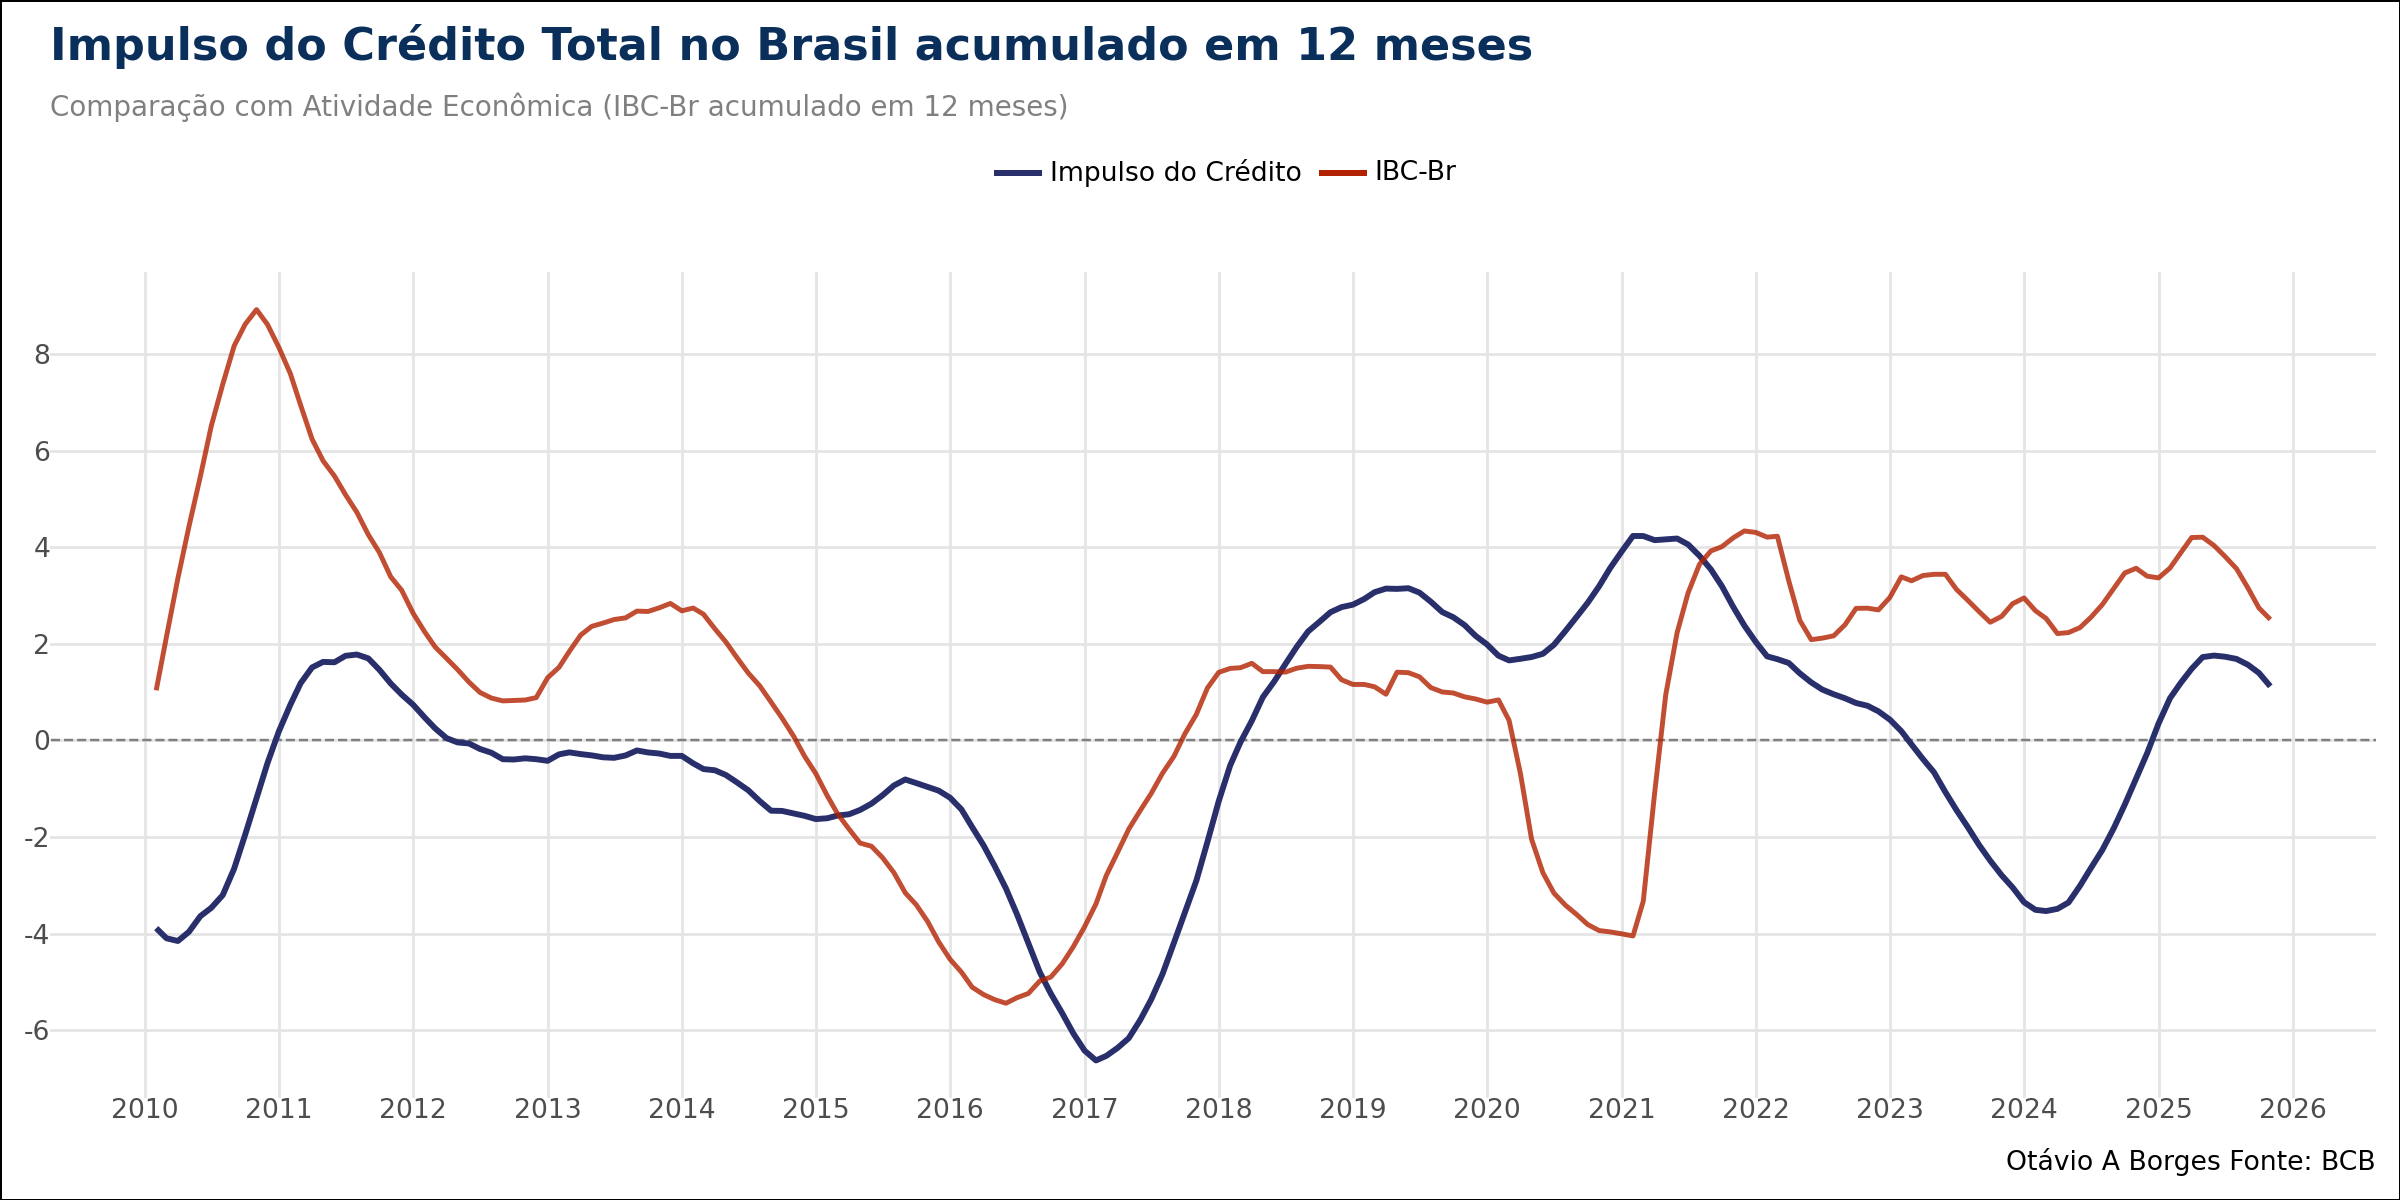

In [ ]:
g1 = (
    ggplot(df_plot, aes(x="date")) +

    geom_hline(yintercept=0, linetype="dashed", color="grey", size=0.5) +

    geom_line(aes(y="impulso_total", color="'Impulso do Crédito'"), size=1.2) +

    geom_line(aes(y="ibc_12m", color="'IBC-Br'"), size=1, alpha=0.8) +

    scale_color_manual(
        values={
            "Impulso do Crédito": cores_am[0],
            "IBC-Br": cores_am[4]
        }
    ) +

    scale_x_date(date_breaks="1 years", date_labels="%Y") +

    scale_y_continuous(
        breaks=range(-10, 11, 2)
    ) +
    labs(
        title="Impulso do Crédito Total no Brasil acumulado em 12 meses",
        subtitle="Comparação com Atividade Econômica (IBC-Br acumulado em 12 meses)",
        x="",
        y="",
        color="",
        caption="Otávio A Borges Fonte: BCB"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=10, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        # Fundo da área do gráfico
        panel_background=element_rect(fill="white"),
        # Fundo externo do gráfico
        plot_background=element_rect(fill="white"),
        figure_size=(12, 6)
    )
)

g1

## Decomposição do Impulso de Crédito

A segregação do impulso entre Recursos Livres e Direcionados revela a heterogeneidade nos canais de transmissão. Enquanto a crise de 2015-2016 foi sistêmica, caracterizada pela retração simultânea da oferta de mercado (aversão a risco) e dos bancos públicos (ajuste fiscal), o ciclo recente apresenta uma divergência notável. A partir de 2021, o segmento de Recursos Livres respondeu com alta sensibilidade ao ciclo de alta da Selic, mergulhando em terreno contracionista conforme o custo de capital se elevava.

Em contrapartida, o segmento de Recursos Direcionados demonstrou maior resiliência, sustentando o impulso total em momentos críticos, amparado provavelmente pela dinâmica de setores específicos como o agronegócio e o imobiliário, que possuem funding menos elástico à taxa básica de juros. O "fundo do poço" em 2023 foi, portanto, um fenômeno essencialmente de mercado. A recuperação projetada para 2025 indica uma normalização qualitativa: a retomada é liderada pela inversão da curva de Recursos Livres, sugerindo que a melhora nas condições financeiras está reativando o apetite de risco das instituições privadas, sem depender excessivamente de indução estatal.

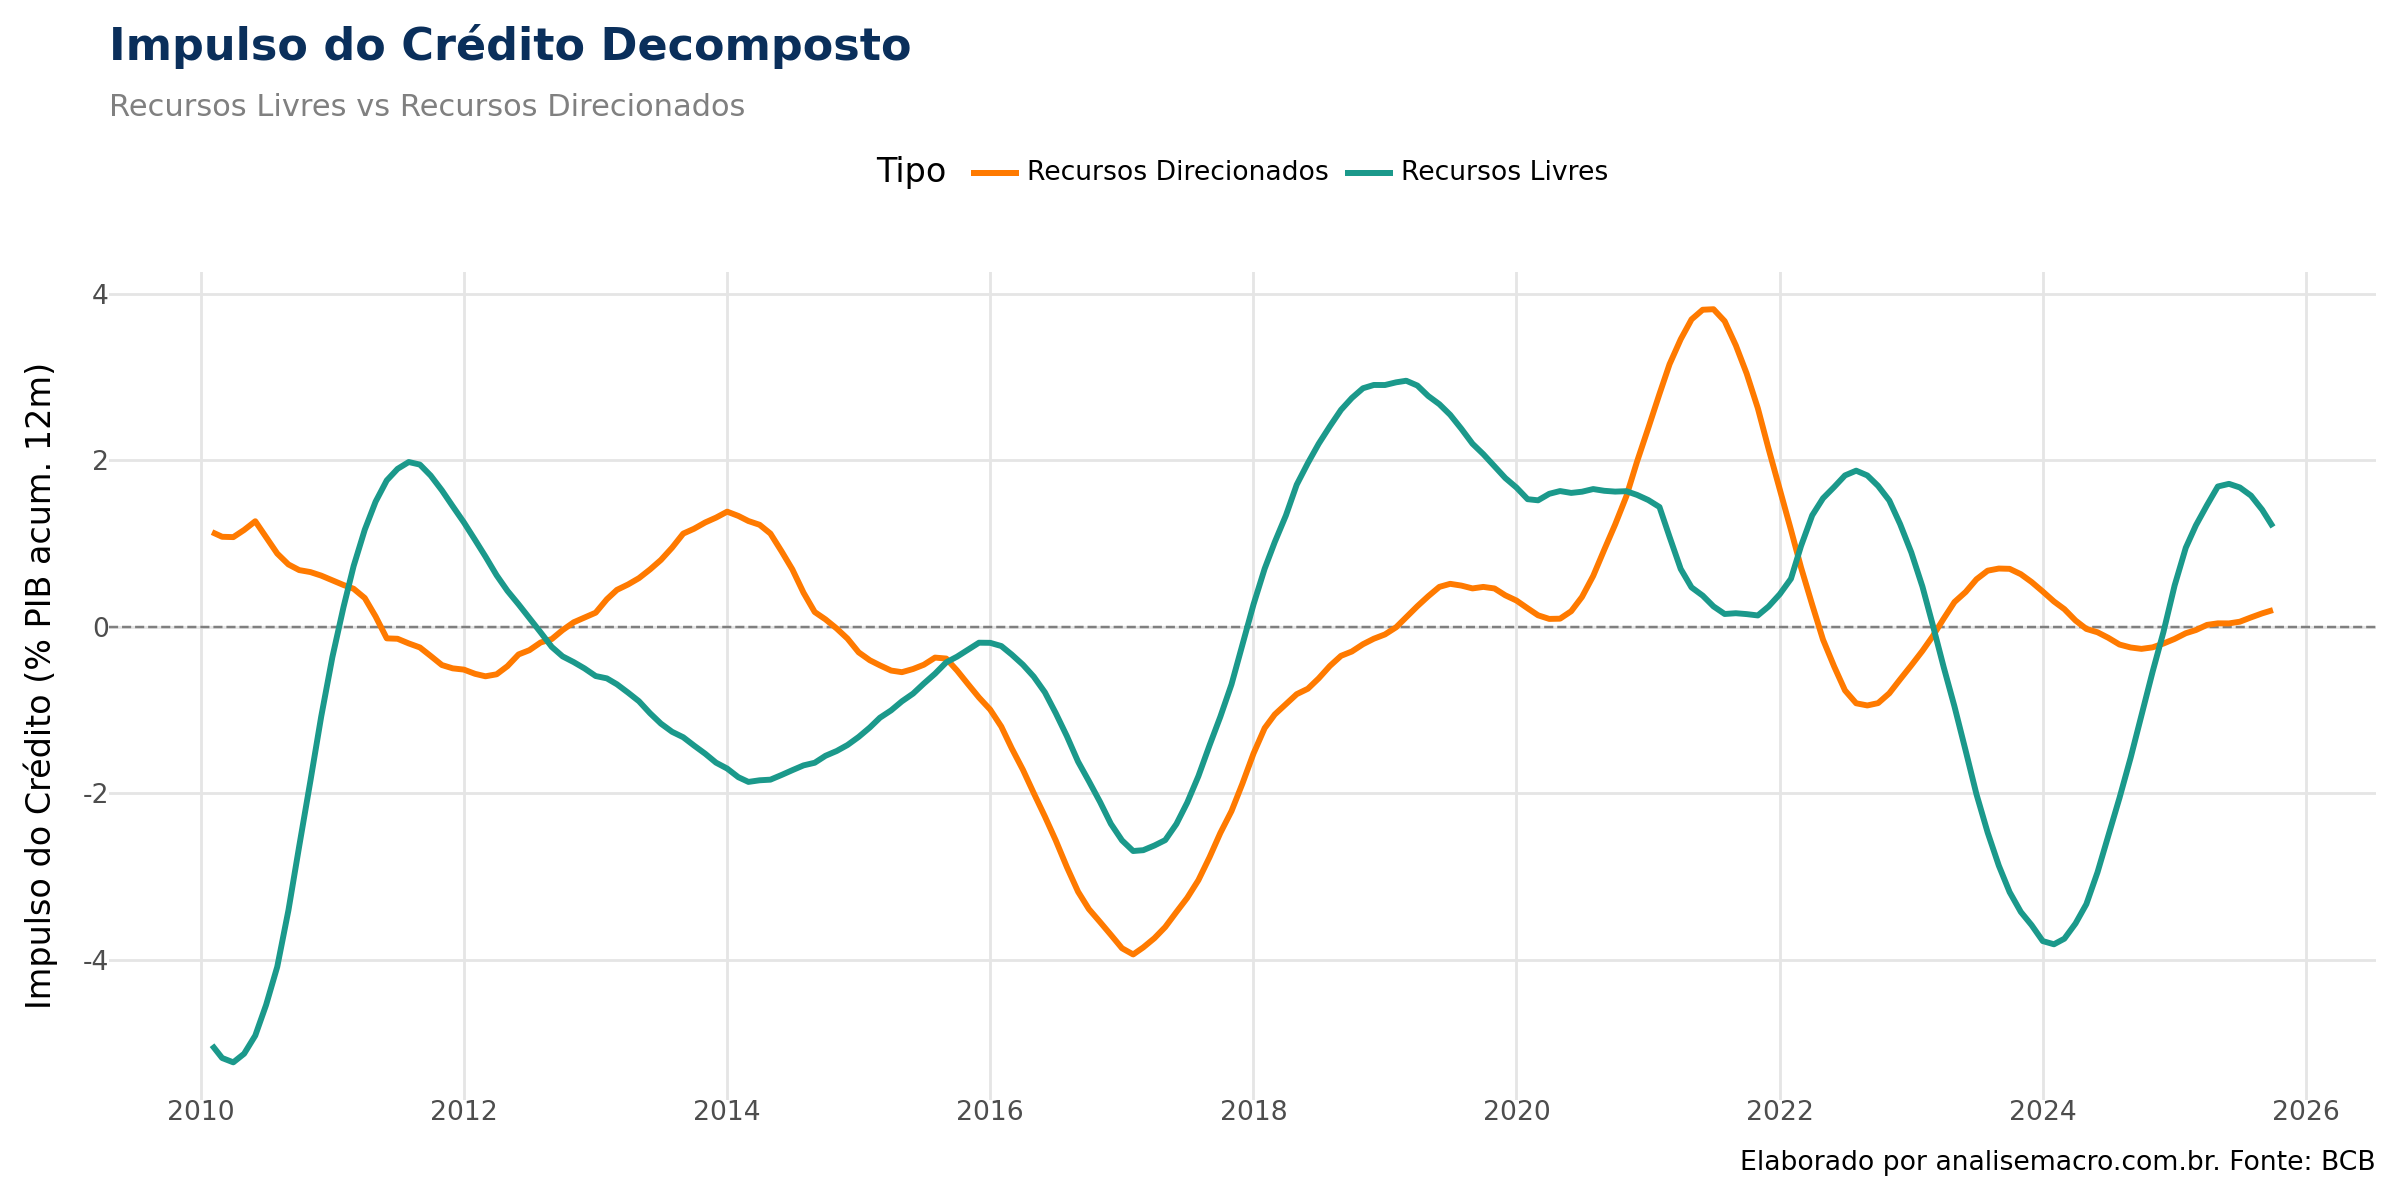

In [ ]:
# Gráfico 2: Impulso Decomposto
df_decomposto_long = pd.melt(
    df_plot[["date", "impulso_livre", "impulso_direcionado"]],
    id_vars=["date"],
    value_vars=["impulso_livre", "impulso_direcionado"],
    var_name="Tipo",
    value_name="Impulso"
)

df_decomposto_long["Tipo"] = df_decomposto_long["Tipo"].map({
    "impulso_livre": "Recursos Livres",
    "impulso_direcionado": "Recursos Direcionados"
})

g2 = (
    ggplot(df_decomposto_long, aes(x="date", y="Impulso", color="Tipo")) +

    geom_hline(yintercept=0, linetype="dashed", color="grey", size=0.5) +

    geom_line(size=1.2) +

    scale_color_manual(
        values={
            "Recursos Livres": cores_am[1],
            "Recursos Direcionados": cores_am[2]
        }
    ) +

    scale_x_date(date_breaks="2 years", date_labels="%Y") +

    labs(
        title="Impulso do Crédito Decomposto",
        subtitle="Recursos Livres vs Recursos Direcionados",
        x="",
        y="Impulso do Crédito (% PIB acum. 12m)",
        color=None,
        caption="Elaborado por analisemacro.com.br. Fonte: BCB"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=11, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        figure_size=(12, 6)
    )
)

g2

In [ ]:
# Preparar dados anuais - último valor de cada ano
df_anual_final = df_plot.copy()
df_anual_final['ano'] = df_anual_final['date'].dt.year

# Pegar apenas o último registro de cada ano
df_anual_final = df_anual_final.groupby('ano').last().reset_index()

# Filtrar anos completos
df_anual_final = df_anual_final[(df_anual_final['ano'] >= 2009) & (df_anual_final['ano'] <= 2024)]

df_anual_final[['ano', 'impulso_total', 'impulso_livre', 'impulso_direcionado']]

,ano,impulso_total,impulso_livre,impulso_direcionado
0,2010,-0.463426,-1.078765,0.615388
1,2011,0.950329,1.449251,-0.498946
2,2012,-0.388311,-0.500059,0.111771
3,2013,-0.319925,-1.631940,1.311994
4,2014,-1.561502,-1.420044,-0.141449
5,2015,-1.040115,-0.190909,-0.849214
6,2016,-6.066513,-2.366167,-3.700342
7,2017,-2.106719,-0.219846,-1.886872
8,2018,2.763021,2.906075,-0.143060
9,2019,2.166588,1.787863,0.378737


In [ ]:
# Preparar dados para barras empilhadas
df_empilhado = pd.melt(
    df_anual_final[['ano', 'impulso_livre', 'impulso_direcionado']],
    id_vars=['ano'],
    value_vars=['impulso_livre', 'impulso_direcionado'],
    var_name='Tipo',
    value_name='Valor'
)

df_empilhado['Tipo'] = df_empilhado['Tipo'].map({
    'impulso_livre': 'Recursos Livres',
    'impulso_direcionado': 'Recursos Direcionados'
})

# Calcular posição dos labels (centro de cada barra)
df_empilhado_sorted = df_empilhado.sort_values(['ano', 'Tipo'], ascending=[True, False])

# Calcular a posição acumulada para cada ano
df_label_pos = []
for ano in df_empilhado_sorted['ano'].unique():
    df_ano = df_empilhado_sorted[df_empilhado_sorted['ano'] == ano].copy()
    df_ano['cum_sum'] = df_ano['Valor'].cumsum()
    df_ano['label_y'] = df_ano['cum_sum'] - (df_ano['Valor'] / 2)
    df_label_pos.append(df_ano)

df_label_pos = pd.concat(df_label_pos, ignore_index=True)

df_label_pos[['ano', 'Tipo', 'Valor', 'label_y']]

,ano,Tipo,Valor,label_y
0,2010,Recursos Livres,-1.078765,-0.539382
1,2010,Recursos Direcionados,0.615388,-0.771071
2,2011,Recursos Livres,1.449251,0.724626
3,2011,Recursos Direcionados,-0.498946,1.199778
4,2012,Recursos Livres,-0.500059,-0.250030
5,2012,Recursos Direcionados,0.111771,-0.444174
6,2013,Recursos Livres,-1.631940,-0.815970
7,2013,Recursos Direcionados,1.311994,-0.975942
8,2014,Recursos Livres,-1.420044,-0.710022
9,2014,Recursos Direcionados,-0.141449,-1.490768


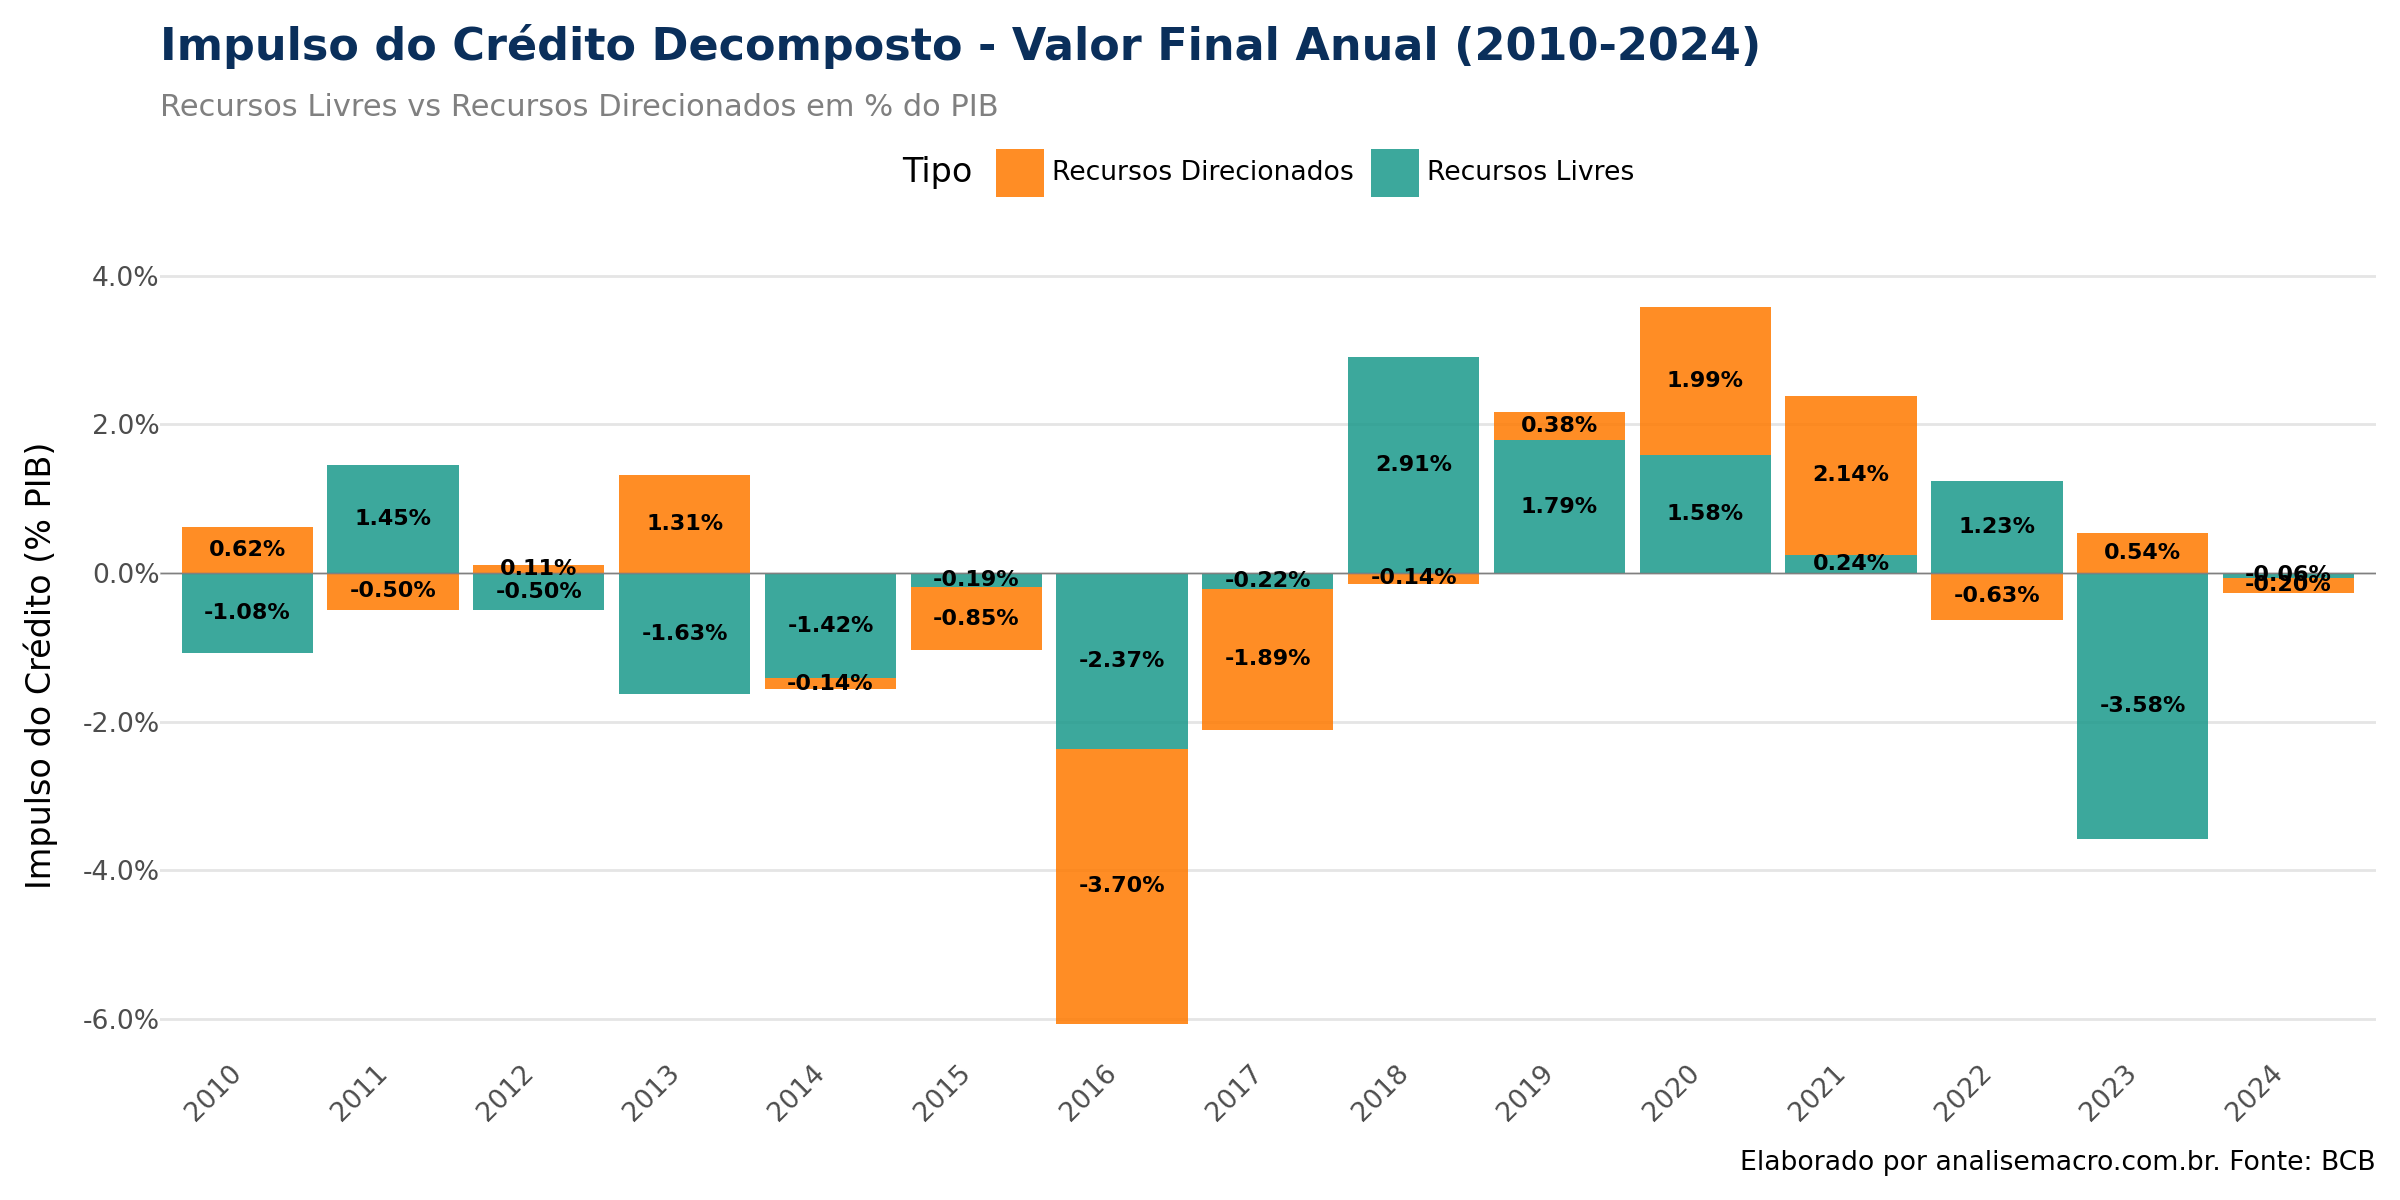

In [ ]:
# Gráfico 3: Barras Empilhadas - Decomposição Anual (valor final do ano)
from plotnine import position_stack

g3 = (
    ggplot(df_empilhado, aes(x='factor(ano)', y='Valor', fill='Tipo')) +

    geom_col(position='stack', alpha=0.85) +

    geom_hline(yintercept=0, linetype="solid", color="grey", size=0.3) +

    geom_text(
        aes(label='Valor'),
        position=position_stack(vjust=0.5),
        size=8,
        format_string='{:.2f}%',
        color='black',
        fontweight='bold'
    ) +

    scale_fill_manual(
        values={
            'Recursos Livres': cores_am[1],
            'Recursos Direcionados': cores_am[2]
        }
    ) +

    scale_y_continuous(
        labels=lambda l: [f'{v:.1f}%' for v in l]
    ) +

    labs(
        title="Impulso do Crédito Decomposto - Valor Final Anual (2010-2024)",
        subtitle="Recursos Livres vs Recursos Direcionados em % do PIB",
        x="",
        y="Impulso do Crédito (% PIB)",
        fill=None,
        caption="Elaborado por analisemacro.com.br. Fonte: BCB"
    ) +

    theme_minimal(base_family="sans", base_size=12) +
    theme(
        plot_title=element_text(face="bold", size=16, color="#0A2F5B"),
        plot_subtitle=element_text(size=11, color="grey"),
        legend_position="top",
        panel_grid_minor=element_blank(),
        panel_grid_major_x=element_blank(),
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(12, 6)
    )
)

g3

## Conclusão

Qual é o papel do crédito no crescimento da economia? Para analisar esta questão, calculamos o indicador de impulso de crédito para a economia brasileira e comparamos com o nível da atividade econômica usando o Python.

## Referências

BIGGS, Michael; MAYER, Thomas; PICK, Andreas. Credit and economic recovery: demystifying phoenix miracles. SSRN Electronic Journal, [S. l.], 2010. Disponível em: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1595980. Acesso em: 06 jan. 2026.

BANCO NACIONAL DE DESENVOLVIMENTO ECONÔMICO E SOCIAL (BNDES). Impulso do crédito. Rio de Janeiro: BNDES, [s.d.]. Disponível em: https://web.bndes.gov.br/bib/jspui/bitstream/1408/23405/1/PRFol_215927_Impulso%20do%20cr%C3%A9dito.pdf. Acesso em: 06 jan. 2026.

BANCO CENTRAL DO BRASIL. Boxe 5: Impulso de crédito. In: Relatório de Inflação: setembro 2021. Brasília: BCB, 2021. Disponível em: https://www.bcb.gov.br/content/ri/relatorioinflacao/202109/ri202109b5p.pdf. Acesso em: 06 jan. 2026.